# Continuous Control

In this notebook, I used the Unity ML-Agents environment for the second project of the Deep Reinforcement Learning Nanodegree program.

## 1. Import necessary packages and start the environment

Here we import our agent class and replay buffer class from `ddpg_agent.py`.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from ddpg_agent import Agent
from ddpg_agent import ReplayBuffer


Next, we will start the Unity environment! **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows (x86)**: `"path/to/Reacher_Windows_x86/Banana.exe"`
- **Windows (x86_64)**: `"path/to/Reacher_Windows_x86_64/Banana.exe"`
- **Linux (x86)**: `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux (x86_64)**: `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux (x86, headless)**: `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux (x86_64, headless)**: `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

After the environment is started, we reset the environment and get the action and state space for instantiating our training agent.

In this work, the 20 agents version of the environment is used. 

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 2. Instantiate agents and replay buffer

All 20 agents are instantiated with a random seed of 2, the random seed can be changed for experiment. 

In [4]:
agents=[Agent(state_size=state_size, action_size=action_size, random_seed=2) for i in range(num_agents)]

We also create a replay buffer to store the combined experience of all 20 agents

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
replay_buffer=ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed=0)

## 3. Training the agents

We defined a function `ddpg` to perform training of the agents. 

In each episode, each agent receive the state and return a action based on that agent's local actor network. Then the action is passed to the environment and the environment outputs the next state, reward and whether the episode is finished. 

After all 20 agents have taken a step, all 20 experiences are added to the shared replay buffer.

For stability of training, the actor and critic networks are only updated every certain steps. Here we used `update_every` of 10, meaning the networks are updated every 10 steps. When the networks are updated, each agent's networks take a random sample from the replay buffer and take a learning step. 

During the training, we track the average score of all 20 agents for each episode. We consider the training is done once the average score of the most recent 100 episodes is higher than 30.0. We save the weight of the agent with the highest score in the last episode to `checkpoint_actor.pth` and `checkpoint_critic.pth` so that it can be loaded in the future. The average score of each episode is plotted as well for visualization.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]
def ddpg(n_episodes=2000, print_every=5,update_every=10):
    scores_deque = deque(maxlen=100)
    average_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        update=0
        while True:
            actions = [agents[i].act(states[i]) for i in range(num_agents)] # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            for i in range(num_agents):          
                replay_buffer.add(states[i],actions[i],rewards[i],next_states[i],dones[i]) # Save experience / reward
            
            if (len(replay_buffer) > BATCH_SIZE) and (update % update_every==0):# Learn, if enough samples are available in memory
                for i in range(num_agents):
                    experiences = replay_buffer.sample()
                    agents[i].learn(experiences, GAMMA)
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            update += 1
            if np.any(dones):                                  # exit loop if episode finished
                break
        scores_deque.append(np.mean(scores))
        average_scores.append(np.mean(scores))
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            num=np.argmax(scores)
            torch.save(agents[np.argmax(scores)].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents[np.argmax(scores)].critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return average_scores

scores = ddpg()

C:\Users\bchao\AppData\Local\Continuum\anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
D:\udacity_DRL\Continuos_Control\ddpg_agent.py:104: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(),1)


Episode 5	Average Score: 0.58
Episode 10	Average Score: 0.70
Episode 15	Average Score: 0.76
Episode 20	Average Score: 0.84
Episode 25	Average Score: 0.86
Episode 30	Average Score: 0.84
Episode 35	Average Score: 0.83
Episode 40	Average Score: 0.83
Episode 45	Average Score: 0.84
Episode 50	Average Score: 0.86
Episode 55	Average Score: 0.87
Episode 60	Average Score: 0.89
Episode 65	Average Score: 0.95
Episode 70	Average Score: 0.99
Episode 75	Average Score: 1.04
Episode 80	Average Score: 1.07
Episode 85	Average Score: 1.11
Episode 90	Average Score: 1.15
Episode 95	Average Score: 1.17
Episode 100	Average Score: 1.22
Episode 105	Average Score: 1.29
Episode 110	Average Score: 1.36
Episode 115	Average Score: 1.42
Episode 120	Average Score: 1.49
Episode 125	Average Score: 1.54
Episode 130	Average Score: 1.61
Episode 135	Average Score: 1.67
Episode 140	Average Score: 1.74
Episode 145	Average Score: 1.80
Episode 150	Average Score: 1.85
Episode 155	Average Score: 1.91
Episode 160	Average Score: 1

The average score of each episode is plotted for visualization.

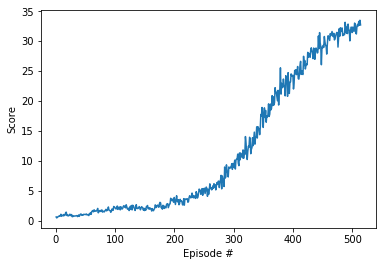

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Close the environment after we are done

In [9]:
env.close()